In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import ticker
from scipy.signal import butter, filtfilt, decimate

In [28]:
def clean_df(path: str) -> pd.DataFrame: 
    """Clean the dataframe so that it has proper column titles."""
    path_df = pd.read_csv(path)
    # duplicate the first row
    path_df.loc[-1] = path_df.columns.tolist()
    path_df.index = path_df.index + 1
    path_df = path_df.sort_index()
    # rename columns
    df_result = path_df.rename(columns={f"{path_df.columns[0]}": "info", f"{path_df.columns[1]}": "info_vals", f"{path_df.columns[2]}": "info_units", f"{path_df.columns[3]}": "time", f"{path_df.columns[4]}": "values"})
    return df_result

def plot_df(signal_df, t_col, v_col): 
    """Plot the dataframe with values over time to visualize the data."""
    figure, axes = plt.subplots(figsize=(20, 5))
    # cast columns to float
    t = signal_df[t_col].astype("float")
    v = signal_df[v_col].astype("float")
    # plot signal
    axes.plot(t, v, linestyle='-', linewidth=0.1)
    plt.show()

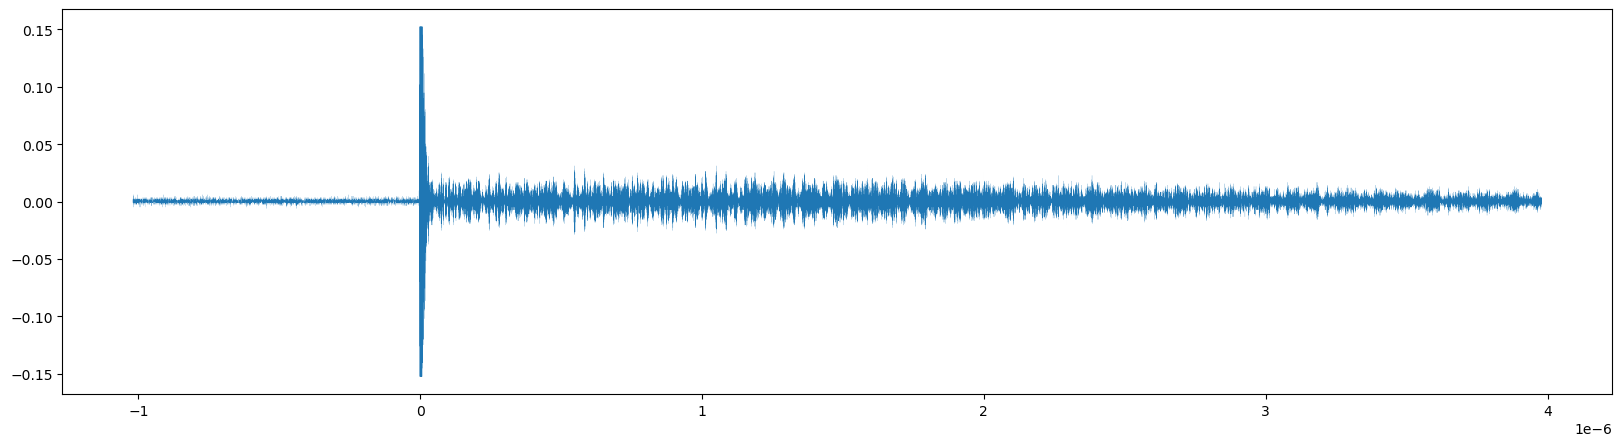

In [29]:
# cannot rewrite with parameters, must be re-structured depending on filenames and local locations
def create_full_df(): 
    """Create a large pandas DataFrame with "time" and "values" columns 
    order: set2_cav1, set2_cav2, set3_cav1, set3_cav2, etc. 
    column names: time_set2_cav1 and values_set2_cav1, etc.
    
    Algorithm: 
    rename the time and values columns for set2_cav1 (time_set2_cav1 and values_set2_cav1) 
    remove the other columns from set2_cav1
    for the rest of the files: 
    - rename their time and values columns following the naming convention 
    - remove their non-time and non-values columns
    - add those columns to the aggregate DataFrame
    return the resulting DataFrame
    """
    
    path_prefix = "/Users/jonathontordilla/Desktop/hombom24/data-collection/scope-analysis/2024-07-03_fast_scope"
    
    df_set2_cav1 = clean_df(path_prefix + "/set2_cav1.csv")
    rename_df_set2_cav1 = df_set2_cav1.rename(columns={"time": "time_set2_cav1", "values": "values_set2_cav1"})
    clean_df_set2_cav1 = rename_df_set2_cav1.loc[0:len(rename_df_set2_cav1["time_set2_cav1"]), "time_set2_cav1": "values_set2_cav1"]
    
    df_set2_cav2 = clean_df(path_prefix + "/set2_cav2.csv")
    rename_df_set2_cav2 = df_set2_cav2.rename(columns={"time": "time_set2_cav2", "values": "values_set2_cav2"})
    clean_df_set2_cav2 = rename_df_set2_cav2.loc[0:len(rename_df_set2_cav2["time_set2_cav2"]), "time_set2_cav2": "values_set2_cav2"]
    
    result_df = pd.concat([clean_df_set2_cav1, clean_df_set2_cav2], axis=1)
    
    for i in range(3, 13): 
        curr_df_cav1 = clean_df(path_prefix + f"/set{i}_cav1.csv")
        curr_df_cav2 = clean_df(path_prefix + f"/set{i}_cav2.csv")

        rename_cav1 = curr_df_cav1.rename(columns={"time": f"time_set{i}_cav1", "values": f"values_set{i}_cav1"})
        clean_cav1 = rename_cav1.loc[0:len(rename_cav1[f"time_set{i}_cav1"]), f"time_set{i}_cav1": f"values_set{i}_cav1"]
        rename_cav2 = curr_df_cav2.rename(columns={"time": f"time_set{i}_cav2", "values": f"values_set{i}_cav2"})
        clean_cav2 = rename_cav2.loc[0:len(rename_cav2[f"time_set{i}_cav2"]), f"time_set{i}_cav2": f"values_set{i}_cav2"]
        
        result_df[f"time_set{i}_cav1"] = clean_cav1[f"time_set{i}_cav1"]
        result_df[f"values_set{i}_cav1"] = clean_cav1[f"values_set{i}_cav1"]
        result_df[f"time_set{i}_cav2"] = clean_cav2[f"time_set{i}_cav2"]
        result_df[f"values_set{i}_cav2"] = clean_cav2[f"values_set{i}_cav2"]
        
    return result_df
        
full_df = create_full_df() # creates a DataFrame will data for all files in 2024-07-03 folder
plot_df(full_df, "time_set4_cav2", "values_set4_cav2") # example: visualize signal over time
# full_df

In [30]:
# Calculations to find the amount of samples per second

first_timestamp = float(full_df["time_set2_cav1"][0])
last_timestamp = float(full_df["time_set2_cav1"].tolist()[-1])
time_range = last_timestamp - first_timestamp
num_samples = len(full_df["time_set2_cav1"])

print(f"Number of samples: {num_samples}")
print(f"Time range: {time_range}")
print(f"Samples per second: {num_samples * (1 / time_range)}")

Number of samples: 50000
Time range: 4.9999e-06
Samples per second: 10000200004.00008


In [31]:
def avg_powers(df: pd.DataFrame) -> pd.DataFrame: 
    """Calculate the average power of the amplitude values in the dataframe."""
    result = {}
    for i in range(2, 13): 
        result[f"set{i}_cav1"] = float(np.mean(np.abs(df[f"values_set{i}_cav1"].astype(float))**2))
        result[f"set{i}_cav2"] = float(np.mean(np.abs(df[f"values_set{i}_cav2"].astype(float))**2))
    return result

avg_powers(full_df)

{'set2_cav1': 0.00031105511589383275,
 'set2_cav2': 8.215710412450717e-05,
 'set3_cav1': 0.00034275706400127846,
 'set3_cav2': 9.144357844140782e-05,
 'set4_cav1': 0.00031024070943219396,
 'set4_cav2': 7.835423662705885e-05,
 'set5_cav1': 0.00033779453559953254,
 'set5_cav2': 8.195510090724972e-05,
 'set6_cav1': 0.00035202617193547326,
 'set6_cav2': 8.309601298123789e-05,
 'set7_cav1': 0.0003798454765272642,
 'set7_cav2': 9.01048391357339e-05,
 'set8_cav1': 0.000312647122412892,
 'set8_cav2': 7.545969238913917e-05,
 'set9_cav1': 0.00031166077993936066,
 'set9_cav2': 7.469997711090973e-05,
 'set10_cav1': 0.0003166324091165718,
 'set10_cav2': 7.718432293780235e-05,
 'set11_cav1': 0.0003360134282732092,
 'set11_cav2': 7.896782064806508e-05,
 'set12_cav1': 0.0003431830736395993,
 'set12_cav2': 8.185438730694875e-05}

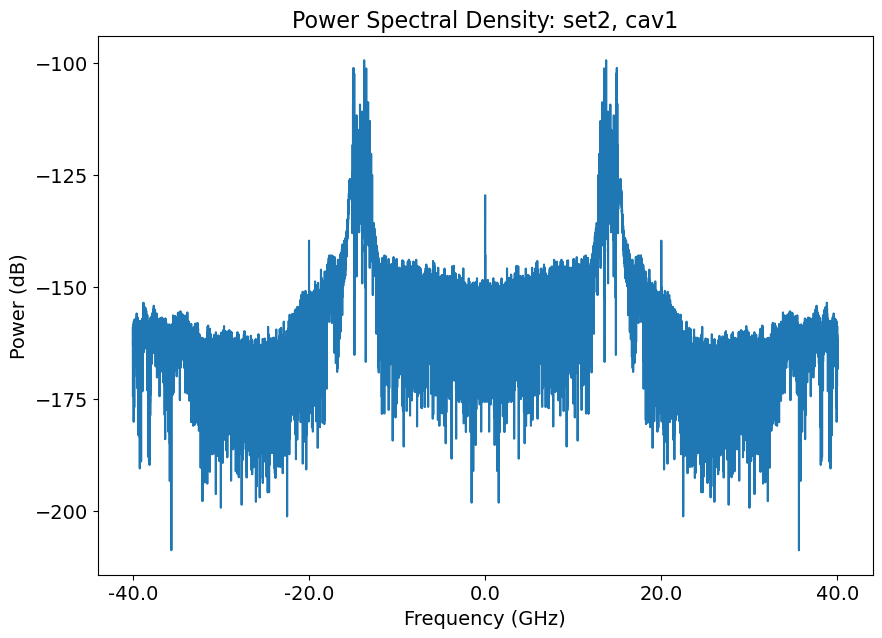

           freq   psd_shift
0 -5.000100e+09 -174.280111
1 -4.999900e+09 -158.945840
2 -4.999700e+09 -165.714570
3 -4.999500e+09 -164.163578
4 -4.999300e+09 -160.895542


In [32]:
def plot_psd(df: pd.DataFrame, column: str, fs: int = 10000200004, fig_width: int = 10, fig_height: int = 7, x_label_font_size: int = 14, y_label_font_size: int = 14, title_font_size: int = 16) -> pd.DataFrame:
    """Calculate and plot the power spectrum of the amplitude values in the dataframe.
    """
    x = df[column].astype("float")
    n = 50000
    psd = np.abs(np.fft.fft(x))**2 / (n*fs)
    psd_log = 10.0*np.log10(psd)
    psd_shifted = np.fft.fftshift(psd_log)
    center_freq = 0
    f = np.arange(fs/-2.0, fs/2.0, fs/n) # start, stop, step centered around 0 Hz
    f += center_freq # now add center frequency
    
    # plot the spectra 
    fig, ax = plt.subplots(figsize = (fig_width, fig_height))
    set_label = ", ".join(column.split("_")[1:])
    ax.set_title(f"Power Spectral Density: {set_label}", fontsize=title_font_size)
    ax.set_xlabel("Frequency (GHz)", fontsize=x_label_font_size)
    ax.set_ylabel("Power (dB)", fontsize=y_label_font_size)
    ax.plot(f, psd_shifted)
    
    # TICK PARAMETERS
    x_tick_locs = ax.get_xticks()
    x_tick_labels = [float((tick.get_text().replace('−', '-')).replace(",", "")) for tick in ax.get_xticklabels()]
    x_tick_labels_new = [round(float(x) * 10, 15) for x in x_tick_labels] # raise or lower to the given power
    ax.xaxis.set_major_locator(ticker.FixedLocator(x_tick_locs))
    ax.xaxis.set_major_formatter(ticker.FixedFormatter(x_tick_labels_new))
    ax.tick_params(axis="x", labelsize=x_label_font_size)
    ax.tick_params(axis="y", labelsize=y_label_font_size)
    ax.xaxis.set_major_locator(plt.MaxNLocator(5))  # reduce the amount of ticks for both axes
    ax.yaxis.set_major_locator(plt.MaxNLocator(5))
    
    plt.show()
    # return the DataFrame of frequencies
    df_freq = pd.DataFrame(data={"freq": f, "psd_shift": psd_shifted})
    return df_freq

psd_df = plot_psd(full_df, "values_set2_cav1")
print(psd_df.head())

## Example: Digital Downconversion 

### WARNING: the following code is partially generated by CHAT-GPT and is used as a learning exercise for implementing a DDC algorithm in python

Digital Downconversion: 
1. Filtering - remove unwanted spectral components, prevent aliasing
2. Mixing - multiply the signal to shift the frequency spectrum
3. Decimation - shift sampling rate to match the new, lower frequency

The following "algorithm" uses the butter, filtfilt, and decimate functions from scipy. 

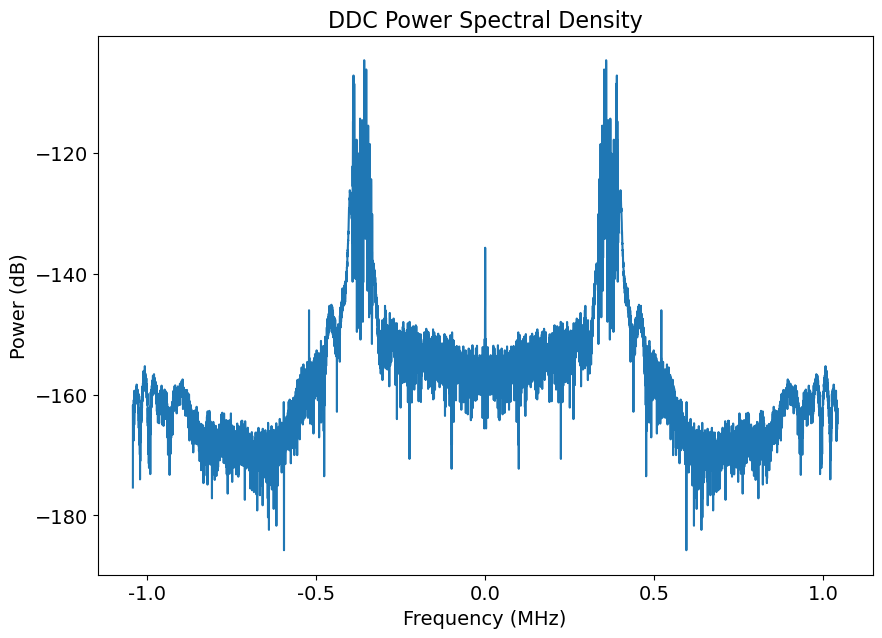

      frequency      psd_db
0 -1.250000e+09 -175.373717
1 -1.249800e+09 -161.750424
2 -1.249600e+09 -163.386444
3 -1.249400e+09 -165.684510
4 -1.249200e+09 -163.078645


In [38]:
def digital_downconversion(df: pd.DataFrame, fc: float, fs: float, decimation_factor: int, fig_width: int = 10, fig_height: int = 7, x_label_font_size: int = 14, y_label_font_size: int = 14, title_font_size: int = 16) -> pd.DataFrame:
    """Perform digital downconversion on a given dataframe of power spectral density.
    
    :param df: Dataframe with 'frequency' and 'psd_db' columns.
    :param fc: Carrier frequency to downconvert from.
    :param fs: Sampling frequency of the original signal.
    :param decimation_factor: Factor by which to decimate the signal.
    
    :param fig_width: Width of the figure.
    :param fig_height: Height of the figure.
    :param x_label_font_size: Font size of the x-axis.
    :param y_label_font_size: Font size of the y-axis.
    :param title_font_size: Font size of the title.
    
    :return: Dataframe with downconverted frequency and psd_db.
    """

    # FREQUENCY SHIFT (Mixing)
    psd_linear = 10**(df['psd_shift'] / 10) # Convert PSD from dB to linear scale
    time = np.arange(len(df))
    carrier = np.exp(-1j * 2 * np.pi * fc * time / fs) # sine function to multiply the signal by, shifts frequency
    mixed_signal = psd_linear * carrier

    # FILTERING (Low-pass filter)
    nyquist_freq = 0.5 * fs  
    # Note by CHAT-GPT: The cutoff frequency is chosen as the Nyquist frequency divided by the decimation factor to ensure 
    # that the filter passes the desired baseband signal while removing higher frequency components that would cause 
    # aliasing during decimation.
    cutoff = nyquist_freq / decimation_factor
    b, a = butter(4, cutoff / nyquist_freq, btype='low') # low pass filter 
    filtered_signal = filtfilt(b, a, mixed_signal) # apply the filter

    # DECIMATION
    decimated_signal = decimate(filtered_signal, decimation_factor) # applies antialiasing filter (order 8 Chebyshev type I) and downsamples
    decimated_psd_db = 10 * np.log10(np.abs(decimated_signal)) # Convert back to dB
    # Create new frequency axis for decimated signal
    decimated_fs = fs / decimation_factor
    decimated_freq = np.linspace(-decimated_fs/2, decimated_fs/2, num=len(decimated_signal))
    
    # PLOTTING 
    downconverted_df = pd.DataFrame({'frequency': decimated_freq, 'psd_db': decimated_psd_db})
    fig, ax = plt.subplots(figsize = (fig_width, fig_height))
    ax.plot(downconverted_df['frequency'], downconverted_df['psd_db'])
    
    # TICK PARAMS
    x_tick_locs = ax.get_xticks()
    x_tick_labels = [float((tick.get_text().replace('−', '-')).replace(",", "")) for tick in ax.get_xticklabels()]
    x_tick_labels_new = [round(float(x), 15) for x in x_tick_labels] # raise or lower to the given power
    ax.xaxis.set_major_locator(ticker.FixedLocator(x_tick_locs))
    ax.xaxis.set_major_formatter(ticker.FixedFormatter(x_tick_labels_new))
    ax.tick_params(axis="x", labelsize=x_label_font_size)
    ax.tick_params(axis="y", labelsize=y_label_font_size)
    ax.xaxis.set_major_locator(plt.MaxNLocator(5))  # reduce the amount of ticks for both axes
    ax.yaxis.set_major_locator(plt.MaxNLocator(5))
    
    ax.set_title("DDC Power Spectral Density", fontsize=title_font_size)
    ax.set_xlabel('Frequency (MHz)', fontsize=x_label_font_size)
    ax.set_ylabel('Power (dB)', fontsize=y_label_font_size)
    plt.show()
    # Return the new dataframe
    return downconverted_df

# Example usage
print(digital_downconversion(psd_df, fc=10e9, fs=10e9, decimation_factor=4).head())